In [1]:
import numpy as np
import pandas as pd
import iminuit
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(16,10)})
plt.style.use('seaborn-whitegrid')

plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 18

Здесь есть проблема с фазовым объёмом трёхчастичного распада

In [3]:
class MDVM():
    def __init__(self):
        self.ALPHA = 7.297e-3
        self.C = 0.389379292e12 #(MeV)^2 * nb

        self.mPhi = 1019.464
        self.mRho = 775.26
        self.mOmg = 782.65

        self.mK0 = 497.6
        self.mP0 = 135.
        self.mKC = 493.677
        self.mPC = 139.57

        self.w0Phi = 4.247
        self.w0Rho = 149.1
        self.w0Omg = 8.49
    
    def BETA(self, s, M_K): #бета
        E = np.sqrt(s)/2.
        P = np.sqrt( E**2 - M_K**2 )
        return P/E
    def PV2(self, s, M, Mn): #фазовый объём распада на 2 одинаковые частицы
        E = np.sqrt(s)/2.
        w = np.where(s <= 4*Mn*Mn, 0, np.power( (s/4. - Mn**2)/((M**2)/4. - Mn**2), 3./2 )*(M**2)/s )
        return w
    def PV3(self, s, MX, m1, m2, m3): #фазовый объём (почти: он типа нормирован) распада на 3 частицы
        #WARNING. TRY TO FIND THE RIGHT VARIANT
        pv = (np.sqrt(s) - m1 - m2 - m3)**2
        pv0 = (np.sqrt(MX*MX) - m1 - m2 - m3)**2
        return pv/pv0
    def PVG(self, s, M, Mn): #распад частицы M на фотон и частицу Mn
        pv  = ((s - Mn**2)/(2*np.sqrt(s)))**3
        pv0 = ((MX**2 - Mn**2)/(2*MX))**3
        return pv/pv0
    
    def WOmg(self, s, W0, MX):    
        Br_3Pi = 0.892    
        Br_Pi0G = 0.084
        Br_2Pi = 0.0153
        ost = 1 - Br_Pi0G - Br_2Pi;
        
        mPC = self.mPC
        mP0 = self.mP0

        W = W0 * ((Br_3Pi + ost) * PV3(s, MX, mPC, mPC, mP0) + \
                  Br_Pi0G * PVG(s, MX, mP0) + Br_2Pi * PV2(s, MX, mPC));
        return W
    def WPhi(self, s, W0, MX):
        Br_KC = 0.492
        Br_KN = 0.34
        Br_3Pi = 0.1524
        Br_EG = 0.01303
        ost = 1 - Br_KC - Br_KN - Br_3Pi - Br_EG

        mEta = 547.862
        mKC = self.mKC
        mK0 = self.mK0
        mPC = self.mPC
        mP0 = self.mP0

        W = W0*((Br_KC + ost)*PV2(s, MX, mKC) + Br_KN*PV2(s, MX, mK0) + \
                Br_3Pi * PV3(s, MX, mPC, mPC, mP0) + Br_EG * PVG(s, MX, mEta));
        return W
    
    def WRhoX(self, s, W0, MX):
        return W0 * self.PV2(s, MX, self.mPC)
    def WOmgX(self, s, W0, MX):
        return W0 * self.PV3(s, MX, self.mPC, self.mPC, self.mP0)
    def WPhiX(self, s, W0, MX):
        return W0 * self.PV2(s, MX, self.mKC)
    
    def BW(self, s, MX, WX0, WX): #функция Брейта-Вигнера
        bw = (MX**2)/( MX**2 - s - 1j*np.sqrt(s)*WX(s, WX0, MX) )
        return bw
    def BW_RhoX(self, s, mX, wX):
        return self.BW(s, mX, wX, self.WRhoX)
    def BW_OmgX(self, s, mX, wX):
        return self.BW(s, mX, wX, self.WOmgX)
    def BW_PhiX(self, s, mX, wX):
        return self.BW(s, mX, wX, self.WPhiX)
    
    def BW_Rho(self, s):
        return self.BW_RhoX(s, self.mRho, self.w0Rho)
    def BW_Omg(self, s):
        return self.BW_OmgX(s, self.mOmg, self.w0Omg)
    def BW_Phi(self, s):
        return self.BW_PhiX(s, self.mPhi, self.w0Phi)
    def BW_Rho1(self, s):
        return self.BW_RhoX(s, 1490, 340)
    def BW_Omg1(self, s):
        return self.BW_OmgX(s, 1420, 220)
    def BW_Rho2(self, s):
        return self.BW_RhoX(s, 1574, 234)
    def BW_Omg2(self, s):
        return self.BW_OmgX(s, 1688, 350)
    def BW_Phi1(self, s, mPhi1, gPhi1):
        return self.BW_PhiX(s, mPhi1, gPhi1)#, 1673, 182)
    def BW_Rho3(self, s): #unused
        return self.BW_RhoX(s, 1720, 250)
    def BW_Rho4(self, s): #unused
        return self.BW_RhoX(s, 1880, 160)
    def BW_Rho5(self, s):
        return self.BW_RhoX(s, 2134, 343)
    def BW_Phi2(self, s):
        return self.BW_PhiX(s, 2198, 71)
    
    #PUBLIC
    def F0(self, x, par, mode=False): #формфактор, нулевое приближение; mode: 0 - short/long; 1 - charged;
        n = par[10] #1.027
        s = (x*1e3)**2
        
        CR = par[0]
        CO = par[1]
        CP = par[2]
        
        KR = CR/2. if mode else -CR/2.
        KO = CO/6.
        KP = CP/3. if mode else n*CP/3.
        
        F = KR * self.BW_Rho(s) + KO * self.BW_Omg(s) + KP * self.BW_Phi(s)
        return F
    def F1(self, x, par, mode=False): #формфактор с учётом omega(1400)
        s = (x*1e3)**2
        
        CR = np.array([par[0], par[3], par[6], par[8]]) # , 1-par[0]-par[3]-par[6] ]
        CO = np.array([par[1], par[4], par[7], par[8]]) # , 1-par[0]-par[3]-par[6] ]
        CP = np.array([par[2], par[5], par[9]])         # , 1-par[2]-par[5], 0 ]
        
        KR = CR/2. if mode else -CR/2.
        KO = CO/6.
        KP = CP/3. #здесь уже нет дополнительного параметра n, как в F0 (в соотв. с моделью)
        
        F1 = self.F0(x, par, mode)
        
        F1 += KR[1] * self.BW_Rho1(s) + KR[2] * self.BW_Rho2(s) + KR[3] * self.BW_Rho5(s)
        F1 += KO[1] * self.BW_Omg1(s) + KO[2] * self.BW_Omg2(s) + KO[3] * self.BW_Rho5(s)
        F1 += KP[1] * self.BW_Phi1(s, par[11], par[12]) + KP[2] * self.BW_Phi2(s)
        return F1
        
    def Cross_Section(self, x, par, mode=False):
        s = (x*1e3)**2
        fabs2 = np.abs( self.F1(x, par, mode) )**2
        M_K = self.mKC if mode else self.mK0
        constant = (np.pi/3.) * (self.ALPHA**2) * self.C
        cs = np.where( x<0.4976*2, 0, constant * (self.BETA(s, M_K)**3) * fabs2 / s  )
        return cs
    def Cross_Section_Neutral(self, x, par):
        return self.Cross_Section(x, par, False)
    def Cross_Section_Charged(self, x, par):
        return self.Cross_Section(x, par, True)    

Получаю данные

In [4]:
#KSKL на phi(1020)
cs_k0k0_phi = pd.read_csv('../formfactor/data/k0k0_koz.dat', delimiter='\t', \
                          names=['index', 'energy', 'energy_err', 'cs', 'cs_err'])
cs_k0k0_phi['energy'] *= 1e-3
cs_k0k0_phi['energy_err'] *= 1e-3
cs_k0k0_phi['cs_err'] = np.sqrt( cs_k0k0_phi.cs_err**2 + (0.018*cs_k0k0_phi.cs)**2 ) #учёт систематики: 1.8% из статьи
cs_k0k0_phi.drop('index', axis=1, inplace=True)

In [5]:
#K+K- на phi(1020)
cs_kpkm_phi = pd.read_csv('../formfactor/data/k+k-_koz.dat', delimiter='\t', \
                          names=['energy', 'energy_err', 'cs', 'cs_err'])
cs_kpkm_phi['energy'] *= 1e-3
cs_kpkm_phi['cs_err'] = np.sqrt( cs_kpkm_phi.cs_err**2 + (0.02*cs_kpkm_phi.cs)**2 )#учёт систематики: мин.2% из статьи
cs_kpkm_phi['energy_err'] *= 1e-3

In [6]:
#K+K- на больших энергиях
cs_kpkm = pd.read_csv('../formfactor/data/k+k-.dat', \
                          names=['energy', 'cs', 'stat', 'syst'])
cs_kpkm['cs_err'] = np.sqrt(cs_kpkm.stat**2 + cs_kpkm.syst**2)
cs_kpkm.drop(['stat','syst'], axis=1, inplace=True)

In [7]:
#Pi+Pi-
cs_pipi = pd.read_csv('../formfactor/data/pi+pi-.dat', names=['energy', 'energy_err', 'cs', 'cs_err'], \
                     delimiter='\t')
cs_pipi['energy'] *= 1e-3

In [8]:
#KSKL
kskl11 = pd.read_csv('../outputs/11/tables/result_visible.csv')#.loc[:25]
kskl12 = pd.read_csv('../outputs/12/tables/result_visible.csv')
kskl17 = pd.read_csv('../outputs/17/tables/result_visible.csv')
kskl19 = pd.read_csv('../outputs/19/tables/result_visible.csv')
radcors = pd.read_csv('../outputs/radcors.dat', names=['energy', 'radcor'])
#                      names=['ff', 'energy', 'de1', 'de2', 'e_err', 'cs', 'cs_err'])
cs_kskl = pd.concat([kskl11, kskl12, kskl17, kskl19], sort=False)
cs_kskl.drop(['name', 'dEmax', 'dEmin'], axis=1, inplace=True)
# cs_kskl.columns = ['energy', 'cs', 'cs_err']
cs_kskl = cs_kskl.rename({'Emean': 'energy', 'CS':'cs', 'dCS':'cs_err'}, axis=1)
cs_kskl['energy'] *= 2e-3

In [9]:
kskl11.head()

,name,dEmin,dEmax,Emean,CSvis,dCSvis,TrigEff,TrigErr,RegEff,RegErr,CS,dCS
0,525.0,0.0,0.0,523.58,1.69314,0.06183,0.5197,0.0202,0.23985,0.00599,13.58314,0.79986
1,537.5,0.0,0.0,537.41,1.59773,0.05462,0.9714,0.0061,0.23985,0.00599,6.85748,0.29345
2,550.0,0.0,0.0,548.44,0.77005,0.04053,0.7381,0.0276,0.23985,0.00599,4.34974,0.30108
3,562.5,0.0,0.0,562.13,0.70477,0.03690,0.9679,0.0099,0.23755,0.00637,3.06522,0.18302
4,575.0,0.0,0.0,575.31,0.32007,0.02631,0.7425,0.0408,0.23815,0.00681,1.81006,0.18630


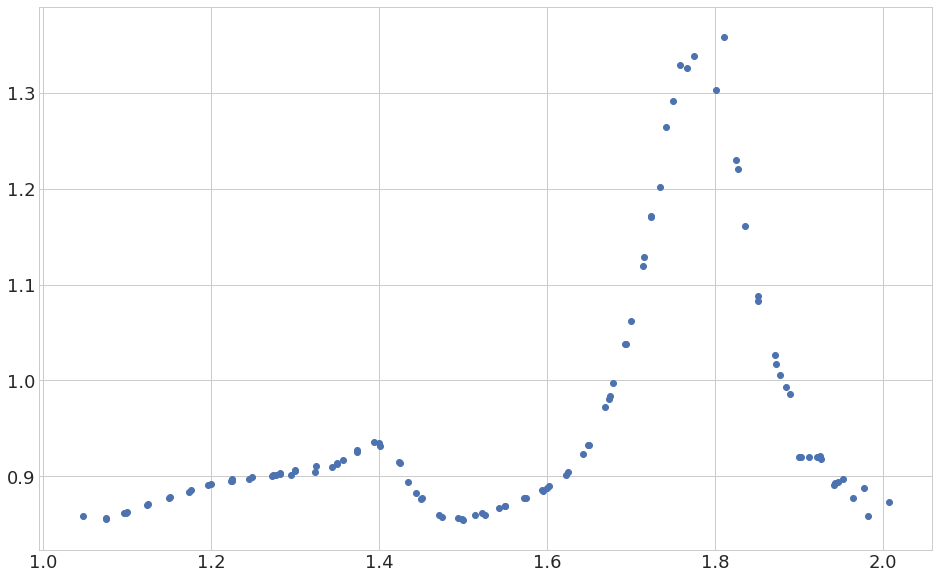

In [10]:
plt.scatter(radcors.energy, radcors.radcor)

In [11]:
cs_kskl['rad'] = np.interp(cs_kskl.energy, radcors.energy, radcors.radcor)
cs_kskl['cs'] /= cs_kskl.rad
cs_kskl['cs_err'] /= cs_kskl.rad

In [12]:
cs_kskl.sort_values('energy').head()

,energy,CSvis,dCSvis,TrigEff,TrigErr,RegEff,RegErr,cs,cs_err,rad
0,1.04716,1.69314,0.06183,0.5197,0.0202,0.23985,0.00599,15.827734,0.932036,0.858186
1,1.07482,1.59773,0.05462,0.9714,0.0061,0.23985,0.00599,8.017744,0.343101,0.855288
0,1.07490,1.56768,0.03644,0.9970,0.0007,0.25148,0.00615,7.310316,0.246612,0.855310
2,1.09688,0.77005,0.04053,0.7381,0.0276,0.23985,0.00599,5.049136,0.349491,0.861482
1,1.09868,0.91434,0.02601,0.9963,0.0009,0.25148,0.00615,4.233351,0.158796,0.862048


Определяю loss function

In [10]:
A = MDVM()

In [11]:
def least_squares(par):
    pred1 = np.square( (cs_k0k0_phi.cs - A.Cross_Section_Neutral(cs_k0k0_phi.energy, par))/cs_k0k0_phi.cs_err ).sum()
    pred2 = np.square( (cs_kpkm_phi.cs - A.Cross_Section_Charged(cs_kpkm_phi.energy, par))/cs_kpkm_phi.cs_err ).sum()
    pred3 = np.square( (cs_kpkm.cs - A.Cross_Section_Charged(cs_kpkm.energy, par))/cs_kpkm.cs_err ).sum()
    pred4 = np.square( (cs_kskl.cs - A.Cross_Section_Neutral(cs_kskl.energy, par))/cs_kskl.cs_err ).sum()
    
    chisq = pred1 + pred2 + pred3 + pred4
    return chisq

In [12]:
names = ['$\\rho$', '$\\omega$', '$\\phi$', '$\\rho\'$', '$\\omega\'$', 
         '$\\phi\'$', '$\\rho\'\'$', '$\\omega\'\'$', '$\\rho\'\'\'$', '$\\phi\'\'$', '$\\eta$', 
         '$m_\\phi\'$', '$\Gamma_\\phi\'$']
# params = [1.531, 1.98, 1.036, -0.165, -0.04, -0.114, -0.032, -0.105, 0.1, 0.1, 0.990]
# params = [1.4801, 2.3298, 1.0286, 0.1841, -0.2127, -0.4767, -0.2382, 1.1164, 0.0465, 0.1012, 0.9926]
# params = [2.2867, 3.9898, 1.027, -0.1721, -0.1931, -0.1285, 0.0, 0.0, 0.0, -0.0698, 1.001] #good params for kskl
params = [1.0294, 0.7998, 1.0405, -0.0568, -0.065, -0.1032, -0.0697, -0.1013, -0.035, 
          -0.0935, 0.9848, 1672.26, 146.9473]
fix_pars = [False, False, False, False, False, False, False, False, False, 
            False, False, False, False] # True False
error_pars = 0.05*np.array(params)

In [15]:
print(list(m.np_values().round(4)))

[1.0294, 0.7998, 1.0405, -0.0568, -0.065, -0.1032, -0.0697, -0.1013, -0.035, -0.0935, 0.9848, 1672.26, 146.9473]


In [14]:
m = iminuit.Minuit.from_array_func(least_squares, params, fix=fix_pars, name=names, \
                                   error=error_pars, errordef=1)
m.get_param_states()

----------------------------------------------------------------------------------------------------
|   | Name           |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
----------------------------------------------------------------------------------------------------
| 0 | $\rho$         |   1.03    |   0.05    |            |            |         |         |       |
| 1 | $\omega$       |   0.80    |   0.04    |            |            |         |         |       |
| 2 | $\phi$         |   1.04    |   0.05    |            |            |         |         |       |
| 3 | $\rho'$        | -0.568E-1 | -0.028E-1 |            |            |         |         |       |
| 4 | $\omega'$      |  -0.065   |  -0.003   |            |            |         |         |       |
| 5 | $\phi'$        |  -0.103   |  -0.005   |            |            |         |         |       |
| 6 | $\rho''$       |  -0.070   |  -0.003   |            |            |         |         |       |
| 7 | $\omega''$     |  -0.101   |  -0.005   |            |            |         |         |       |
| 8 | $\rho'''$      | -0.350E-1 | -0.018E-1 |            |            |         |         |       |
| 9 | $\phi''$       |  -0.093   |  -0.005   |            |            |         |         |       |
| 10| $\eta$         |   0.98    |   0.05    |            |            |         |         |       |
| 11| $m_\phi'$      |   1670    |    80     |            |            |         |         |       |
| 12| $\Gamma_\phi'$ |    147    |     7     |            |            |         |         |       |
----------------------------------------------------------------------------------------------------

In [16]:
m.migrad()

------------------------------------------------------------------
| FCN = 458.5                   |     Ncalls=777 (777 total)     |
| EDM = 1.07E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
|   | Name           |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
----------------------------------------------------------------------------------------------------
| 0 | $\rho$         |   1.157   |   0.024   |            |            |         |         |       |
| 1 | $\omega$       |   0.42    |   0.07    |            |            |         |         |       |
| 2 | $\phi$         |   1.040   |   0.003   |            |            |         |         |       |
| 3 | $\rho'$        |  -0.055   |   0.005   |            |            |         |         |       |
| 4 | $\omega'$      |  -0.070   |   0.009   |            |            |         |         |       |
| 5 | $\phi'$        |  -0.077   |   0.012   |            |            |         |         |       |
| 6 | $\rho''$       | -0.608E-1 |  0.030E-1 |            |            |         |         |       |
| 7 | $\omega''$     |   -0.21   |    0.03   |            |            |         |         |       |
| 8 | $\rho'''$      | -2.75E-2  |  0.19E-2  |            |            |         |         |       |
| 9 | $\phi''$       |  -0.102   |   0.004   |            |            |         |         |       |
| 10| $\eta$         |   0.984   |   0.003   |            |            |         |         |       |
| 11| $m_\phi'$      |  1668.3   |    2.1    |            |            |         |         |       |
| 12| $\Gamma_\phi'$ |    134    |    11     |            |            |         |         |       |
----------------------------------------------------------------------------------------------------

Plotting

In [94]:
box_1 = {'facecolor':'black', 'boxstyle': 'round'}

In [95]:
params = m.np_values()

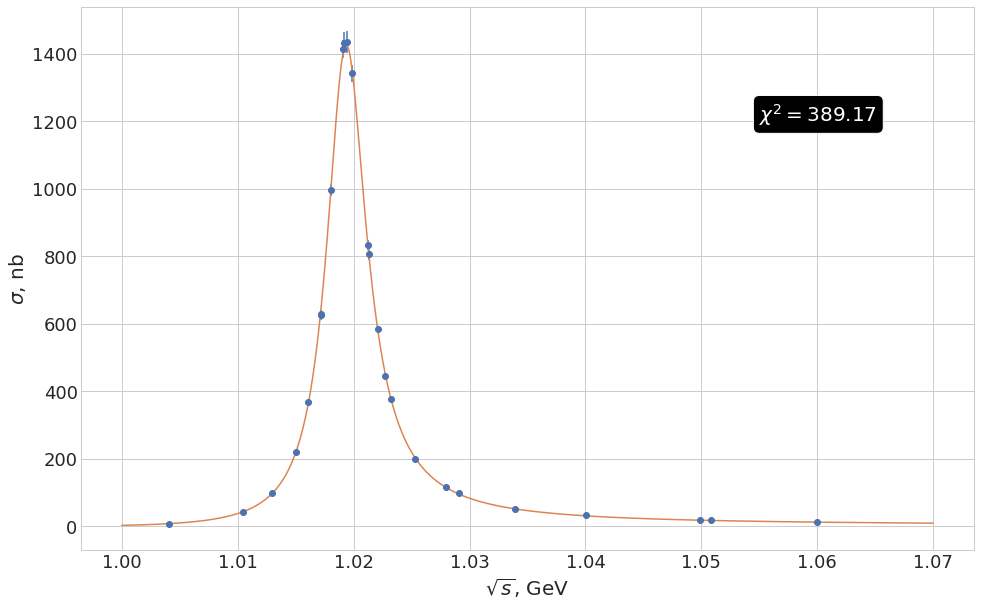

In [96]:
#Fitting line
plt.errorbar(data=cs_k0k0_phi, x='energy', y='cs', xerr='energy_err', yerr='cs_err', fmt='o')

#Experimental points
x_k0k0_phi = np.linspace(1., 1.07, 1000)
plt.plot(x_k0k0_phi, A.Cross_Section_Neutral(x_k0k0_phi, params) )

#Text and labels
plt.xlabel('$\sqrt{s}$, GeV', fontsize=20)
plt.ylabel('$\sigma$, nb', fontsize=20)
ax = plt.gca()
text_label = f"$\chi^2 = {least_squares(params):.2f}$"
ax.text(1.055, 1200, text_label, bbox=box_1, color='white', fontsize=20)
ax.tick_params(labelsize=18);

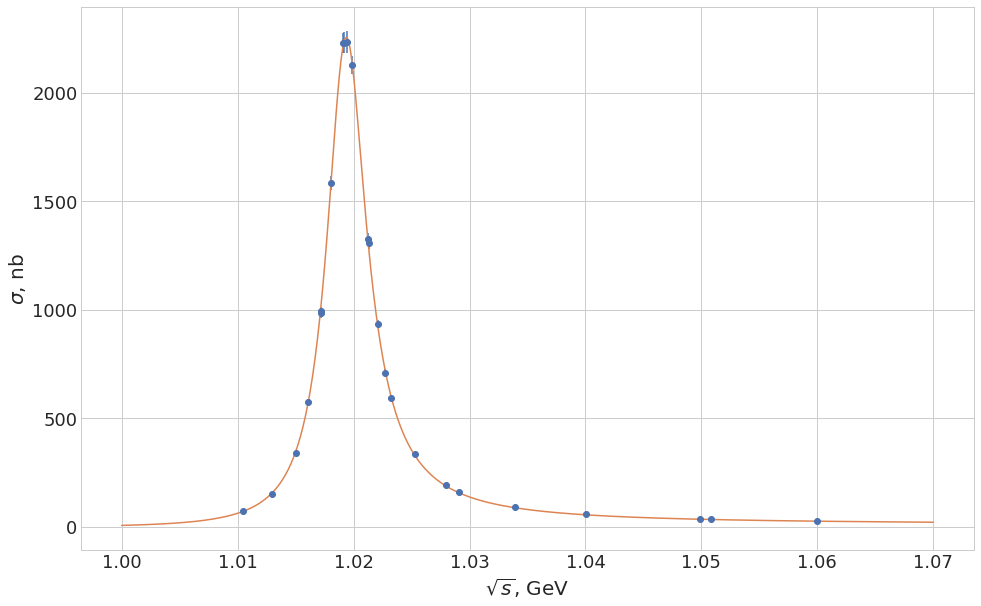

In [97]:
plt.errorbar(data=cs_kpkm_phi, x='energy', y='cs', xerr='energy_err', yerr='cs_err', fmt='o')

x_kpkm_phi = np.linspace(1., 1.07, 1000)
plt.plot(x_k0k0_phi, A.Cross_Section_Charged(x_kpkm_phi, params) )

ax = plt.gca()
plt.xlabel('$\sqrt{s}$, GeV');
plt.ylabel('$\sigma$, nb');

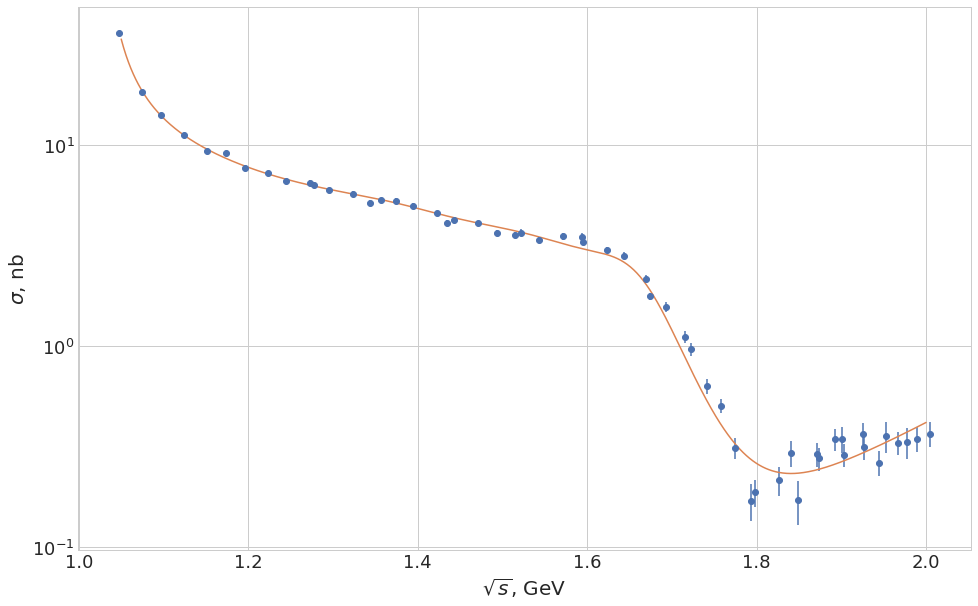

In [62]:
plt.errorbar(data=cs_kpkm, x='energy', y='cs', yerr='cs_err', fmt='o')

x_kpkm = np.linspace(1.05, 2., 1000)
plt.plot(x_kpkm, A.Cross_Section_Charged(x_kpkm, params) )
plt.yscale('log')

ax = plt.gca()
plt.xlabel('$\sqrt{s}$, GeV');
plt.ylabel('$\sigma$, nb');

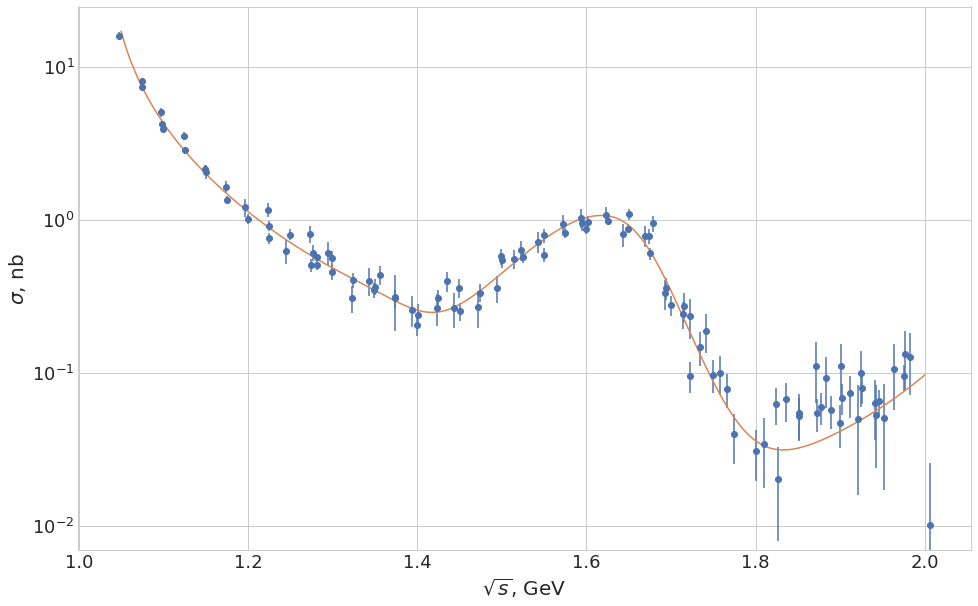

In [63]:
plt.errorbar(data=cs_kskl, x='energy', y='cs', yerr='cs_err', fmt='o')

x_kskl = np.linspace(1.05, 2., 1000)
plt.plot(x_kskl, A.Cross_Section_Neutral(x_kskl, params) )
plt.yscale('log')

ax = plt.gca()
plt.xlabel('$\sqrt{s}$, GeV');
plt.ylabel('$\sigma$, nb');

Вот тут вопрос: если точка находится выше чем кривая, то рад.поправка например будет больше чем у точки под кривой, таким образом можно было бы сильнее подсобрать данные, но как это сделать и учесть?

Save fitting cross section

In [46]:
df_crosssec = pd.DataFrame()

In [47]:
df_crosssec['x'] = np.linspace(1.0, 2.10, 2100)
df_crosssec['c'] = A.Cross_Section_Neutral(df_crosssec.x, params).round(3)

In [48]:
df_crosssec['x'] = (df_crosssec.x*1e3).round(2)

In [40]:
df_crosssec.to_csv('../inputs/radcors/cstest.dat', sep=' ', header=None)

In [112]:
np.savetxt('../inputs/radcors/cs.dat', df_crosssec, delimiter=' ', fmt='%.2f')

In [41]:
df_crosssec

,x,c
0,1000.0,1.803
1,1002.0,3.703
2,1004.0,6.815
3,1006.0,11.966
4,1008.0,20.814
...,...,...
545,2092.0,0.368
546,2094.0,0.381
547,2096.0,0.394
548,2098.0,0.409


Calculate new rad corrections

In [67]:
%%bash
cd 
source programs/root/bin/thisroot.sh
cd ~/projects/ROOT/research/code
root -l radcors.cpp


Processing radcors.cpp...
EnergyFile name is ../inputs/radcors/energies.dat
Reaction threshold is 0.9952, GeV
Cross Section File Name is ../inputs/radcors/cs.dat
Successful reading... Cross section File contains 2000 records
Successful reading... Energy File contains 110 records

Radiative corrections calculation started..

dE: 11.221 MeV
Radiative correction at E = 1.04716 GeV is equal to 0.858186
	Time of this calculation: 2 seconds

dE: 15.4782 MeV
Radiative correction at E = 1.07482 GeV is equal to 0.855288
	Time of this calculation: 1 seconds

dE: 18.8814 MeV
Radiative correction at E = 1.09688 GeV is equal to 0.861482
	Time of this calculation: 1 seconds

dE: 23.1621 MeV
Radiative correction at E = 1.12426 GeV is equal to 0.870086
	Time of this calculation: 2 seconds

dE: 27.3565 MeV
Radiative correction at E = 1.15062 GeV is equal to 0.878029
	Time of this calculation: 1 seconds

dE: 31.155 MeV
Radiative correction at E = 1.1741 GeV is equal to 0.884068
	Time of this calculatio